In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib.pyplot as plt
from keras import callbacks
import numpy as np

In [3]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary') 

validation_generator = val_datagen.flow_from_directory(
        '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [4]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train',
    labels='inferred',
    batch_size=32,
    image_size=(224,224),

)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation',
    labels='inferred',
    batch_size=32,
    image_size=(224,224),

)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


In [5]:
class_names = train_ds.class_names

In [6]:
class_names

['WithMask', 'WithoutMask']

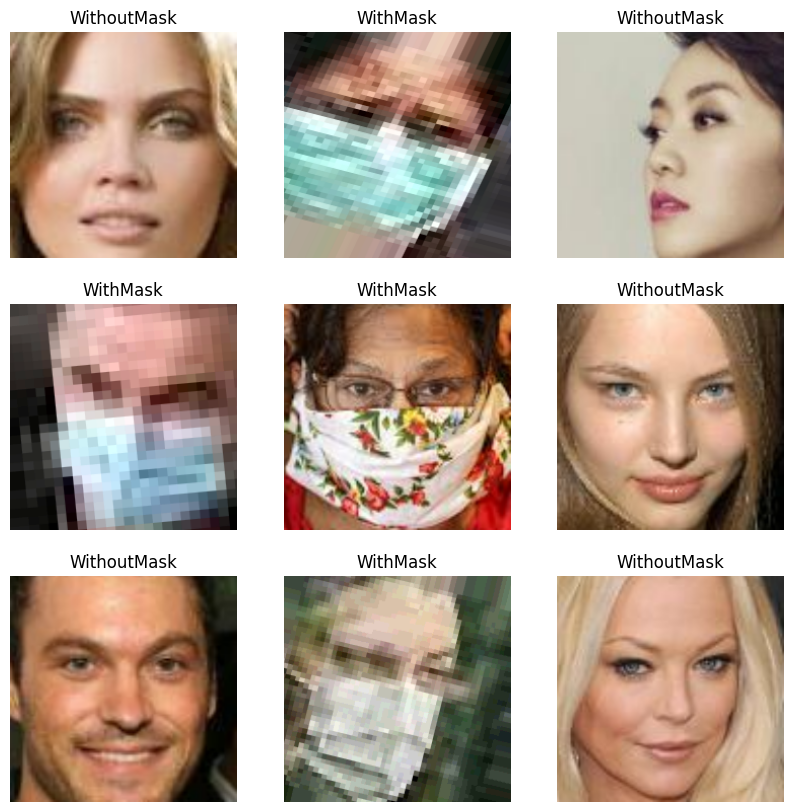

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [9]:
def process_image(image, label):
    image = tf.cast(image/255. , tf.float32)
    return image, label

train_ds = train_ds.map(process_image)
validation_ds = validation_ds.map(process_image)

In [10]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [12]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
history = model.fit(train_ds,epochs=2, validation_data=validation_ds)

Epoch 1/2
313/313 [==============================] - 629s 2s/step - loss: 0.0452 - accuracy: 0.9840 - val_loss: 0.0116 - val_accuracy: 0.9975
Epoch 2/2
313/313 [==============================] - 618s 2s/step - loss: 0.0229 - accuracy: 0.9920 - val_loss: 0.0224 - val_accuracy: 0.9912


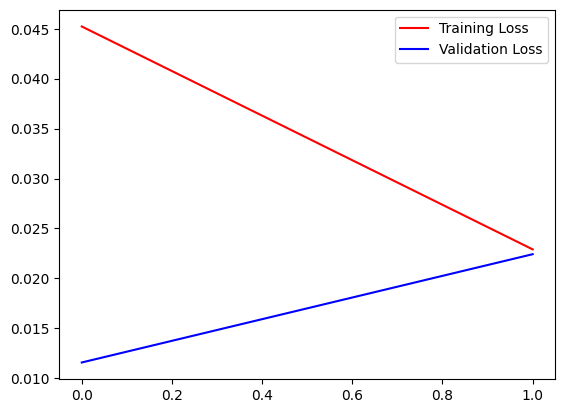

In [15]:
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.legend()
plt.show()

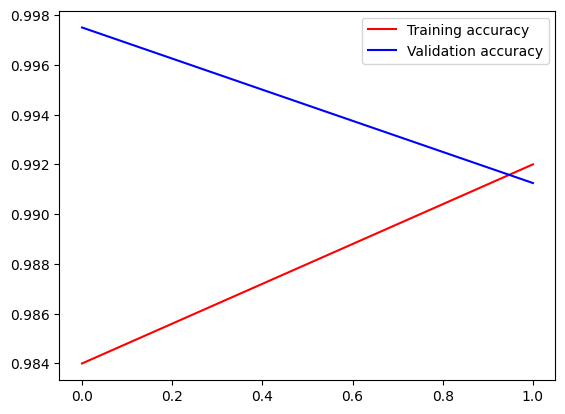

In [16]:
plt.plot(history.history['accuracy'], label='Training accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.legend()
plt.show()

In [17]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

58889256/58889256 [==============================] - 3s 0us/step


In [18]:
model_vgg = Sequential()
model_vgg.add(conv_base)
model_vgg.add(Flatten())
model_vgg.add(Dense(256,activation='relu'))
model_vgg.add(Dense(1,activation='sigmoid'))

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


In [19]:
conv_base.trainable = False

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
model_vgg.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [22]:
history_aug = model_vgg.fit(
        train_generator,
        epochs=2,
        validation_data=validation_generator)

Epoch 1/2
313/313 [==============================] - 3073s 10s/step - loss: 0.0948 - accuracy: 0.9683 - val_loss: 0.0201 - val_accuracy: 0.9925
Epoch 2/2
313/313 [==============================] - 3062s 10s/step - loss: 0.0407 - accuracy: 0.9849 - val_loss: 0.0172 - val_accuracy: 0.9937


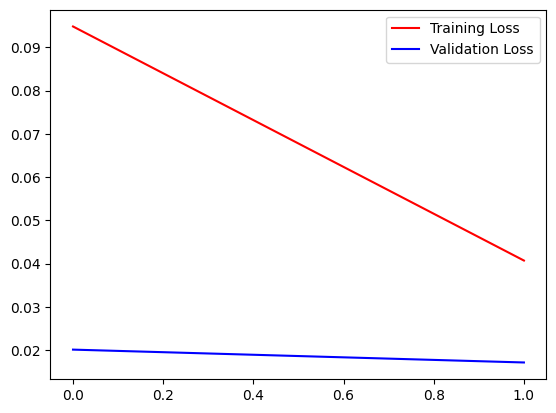

In [23]:
plt.plot(history_aug.history['loss'], label='Training Loss', color='red')
plt.plot(history_aug.history['val_loss'], label='Validation Loss', color='blue')
plt.legend()
plt.show()

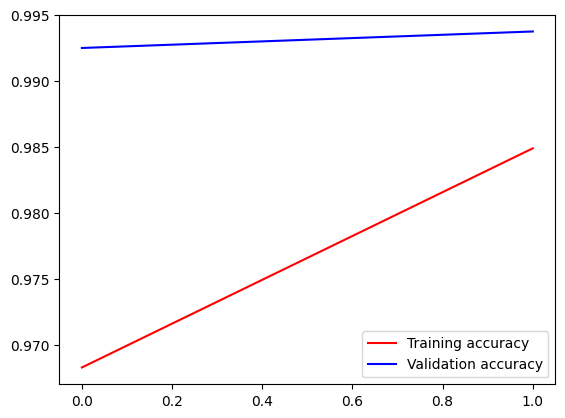

In [24]:
plt.plot(history_aug.history['accuracy'], label='Training accuracy', color='red')
plt.plot(history_aug.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.legend()
plt.show()

In [25]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test',
    labels='inferred',
    batch_size=32,
    image_size=(224,224),
    shuffle=False

)

Found 992 files belonging to 2 classes.


In [26]:
test_ds = test_ds.map(process_image)


In [27]:
test_score = model_vgg.evaluate(test_ds)

print(test_score[1])

31/31 [==============================] - 278s 9s/step - loss: 0.0223 - accuracy: 0.9909
0.9909273982048035


In [28]:
y_preds = model_vgg.predict(test_ds)

31/31 [==============================] - 277s 9s/step


In [29]:
y_preds=y_preds.flatten().astype('int32')

In [30]:
y_test = np.concatenate([y for x, y in test_ds], axis=0) 

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

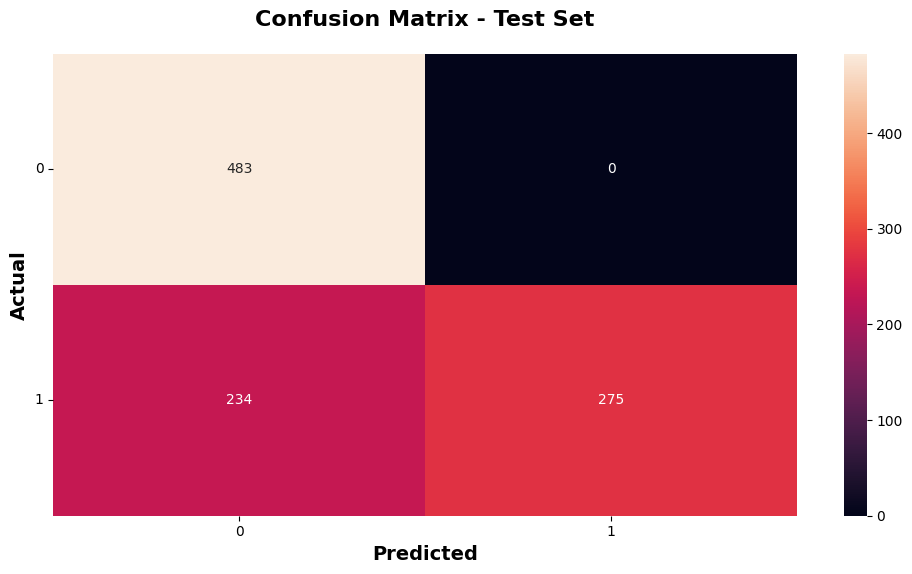

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import seaborn as sns

#ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_preds);
#test_pred = model.predict(test_ds)
#test_pred = np.argmax(test_pred,axis = 1)
#test_labels = np.concatenate([y for x, y in test_ds], axis=0) 

plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    y_test,
    y_preds,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [32]:
import cv2
cap = cv2.VideoCapture(0)

[ WARN:0] global /tmp/pip-req-build-4x5kub8r/opencv/modules/videoio/src/cap_v4l.cpp (890) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


In [33]:
def draw_label(img,text,pos,bg_color):
    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX,1, cv2.FILLED)
    end_x = pos[0] + text_size[0][0] + 2
    end_y = pos[1] + text_size[0][1] - 2

    cv2.rectangle(img, pos, (end_x,end_y), bg_color, cv2.FILLED)
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv2.LINE_AA)

In [34]:
def detect_face_mask(img):
    y_pred = model_vgg.predict(img.reshape(1,224,224,3), verbose=0)
    #y_pred = model_vgg.predict(img, verbose=0)
  #np.where(y_pred[0][0] > 0.5, 1,0)
  #y_pred = (model.predict(img.reshape(1,224,224,3), verbose=0) > 0.5).astype("int32")
    if y_pred[0][0] >= 0.5:
        return 1
    else:
        return 0

In [88]:
sample_1 = cv2.imread('/kaggle/input/img2jpeg/img2.jpeg')
sample_1 = cv2.resize(sample_1,(224,224))
sample_mask_img = np.reshape(sample_1,[1,224,224,3])
sample_mask_img = sample_mask_img/255.0

In [89]:
detect_face_mask(sample_mask_img)

0

In [85]:
import cv2
import numpy as np
from keras.models import load_model

# Load the pre-trained face detection classifier
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Load the pre-trained face mask detection model
model = load_model('mask_detector.h5')

# Open the camera
cap = cv2.VideoCapture(0)

while True:
    # Capture a frame from the camera
    ret, frame = cap.read()
    
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))
    
    # Loop over each detected face
    for (x, y, w, h) in faces:
        # Extract the face ROI and preprocess it
        face_roi = gray[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (224, 224))
        face_roi = np.expand_dims(face_roi, axis=-1)
        face_roi = np.expand_dims(face_roi, axis=0)
        face_roi = face_roi / 255.0
        
        # Predict whether the person is wearing a mask or not
        pred = model.predict(face_roi)[0]
        
        # Overlay the result on the video stream
        label = "Mask" if pred < 0.5 else "No mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    
    # Display the output
    cv2.imshow('Face Mask Detector', frame)
    
    # Check for user input to quit the program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the resources
cap.release()
cv2.destroyAllWindows()


OSError: No file or directory found at mask_detector.h5